In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

/Users/lucienwalewski/Library/CloudStorage/OneDrive-Personal/ETH/Year 1/Spring/Computational Intelligence Lab/Project/collaborative_filtering/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Preprocessing

In [2]:
data = pd.read_csv('../data/data_train.csv', index_col=0)

# rename column and turn ot uint8
data.rename(columns={'Prediction': 'Rating'}, inplace=True)
data['Rating'] = data['Rating'].astype('uint8')

# get user and movie id by splitting index given in format rX_cY
data['UserId'] = data.index.str.split('_').str[0].str[1:].astype('int32')
data['MovieId'] = data.index.str.split('_').str[1].str[1:].astype('int32')

# subtract min UserId and MovieID to get indices starting at 0
data['UserId'] = data['UserId'] - data['UserId'].min()
data['MovieId'] = data['MovieId'] - data['MovieId'].min()

# reorder columns to UserId, MovieId, Rating
data = data[['UserId', 'MovieId', 'Rating']]

# split into train and val data
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

In [3]:
train_data.head()

,UserId,MovieId,Rating
Id,,,
r5874_c663,5873,662,5
r4711_c367,4710,366,4
r2539_c435,2538,434,1
r7737_c558,7736,557,2
r9631_c791,9630,790,5


In [4]:
train_data.describe()

,UserId,MovieId,Rating
count,941561.000000,941561.000000,941561.000000
mean,5149.112369,482.580407,3.856588
std,2918.447452,274.174986,1.119108
min,0.000000,0.000000,1.000000
25%,2602.000000,246.000000,3.000000
50%,5247.000000,493.000000,4.000000
75%,7734.000000,690.000000,5.000000
max,9999.000000,999.000000,5.000000


In [5]:
train_mean = train_data['Rating'].mean()
train_std = train_data['Rating'].std()

# standardize ratings
train_data['Rating'] = (train_data['Rating'] - train_mean) / train_std

In [6]:
# function to get sparse matrix from data given as a dataframe with row and column indices
def get_sparse_matrix(data, n_rows, n_cols):
    return csr_matrix((data['Rating'].values, (data['UserId'].values, data['MovieId'].values)), shape=(n_rows, n_cols))

n_rows = train_data['UserId'].max() + 1 # might raise errors if in val set user with larger id
n_cols = train_data['MovieId'].max() + 1 # might raise errors if in val set movie with larger id
train_matrix = get_sparse_matrix(train_data, n_rows, n_cols)

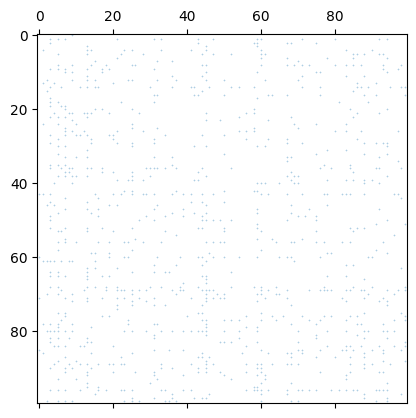

In [7]:
# plot sparse matrix
plt.spy(train_matrix[:100,:100], markersize=0.1)
plt.show()

# ALS algorithm

In [8]:
# function to compute loss
def loss_func(U, V, A, lam):
    loss = 0
    for row in range(n_rows):
        for col in range(n_cols):
            if A[row,col]:
                loss += (A[row,col] - U[row,:] @ V[:,col])**2
    loss += lam * (np.linalg.norm(U)**2 + np.linalg.norm(V)**2)
    return loss

In [9]:
rank = 20 # number of latent factors
lam = 0.1 # regularization parameter

# only consider subset
n_rows, n_cols = 1000, 100

# initialize U and V
A = train_matrix[:n_rows, :n_cols]
U = np.random.rand(n_rows, rank)
V = np.random.rand(rank, n_cols)

# function to make one step
def make_step(U, V, A, lam):
    for i in tqdm(range(n_rows)):
        U[i] = np.linalg.inv(np.sum([np.where(A[i, j], np.expand_dims(V[:, j], 1) @ np.expand_dims(V[:, j], 1).T, 0) for j in range(n_cols)], axis=0) + lam * np.identity(rank)) @ np.sum([np.where(A[i, j], A[i, j] * V[:, j], 0) for j in range(n_cols)], axis=0)
    for j in tqdm(range(n_cols)):
        V.T[j] = np.linalg.inv(np.sum([np.where(A[i, j], np.expand_dims(U[i], 1) @ np.expand_dims(U[i], 1).T, 0) for i in range(n_rows)], axis=0) + lam * np.identity(rank)) @ np.sum([np.where(A[i, j], A[i, j] * U[i], 0) for i in range(n_rows)], axis=0)

In [10]:
# make steps until convergence
losses = []
for i in range(10):
    make_step(U, V, A, lam)
    loss = loss_func(U, V, A, lam)
    losses.append(loss)
    print('Step: {}, Loss: {}'.format(i, loss))

100%|██████████| 100/100 [00:13<00:00,  7.41it/s]


Step: 0, Loss: 1252.7940082154116


100%|██████████| 100/100 [00:14<00:00,  7.10it/s]


Step: 1, Loss: 875.7020706052106


100%|██████████| 100/100 [00:13<00:00,  7.66it/s]


Step: 2, Loss: 711.6598196606135


100%|██████████| 100/100 [00:13<00:00,  7.32it/s]


Step: 3, Loss: 612.8425103993977


100%|██████████| 100/100 [00:14<00:00,  6.69it/s]


We try a more efficient approach

In [ ]:
# TODO: Update make_step to remove for loops
# TODO: Update loss function implementation